In [1]:
%matplotlib widget
import matplotlib.pyplot as plt


In [2]:
# get the images for the spair Train train datasets
import glob
import os 
img_dir = "/home/tlips/Code/few-shot-keypoints/data/SPair-71k/JPEGImages/bicycle"

images = glob.glob(os.path.join(img_dir, "*.jpg"))

print(len(images))

100


In [3]:
# create featurizer 



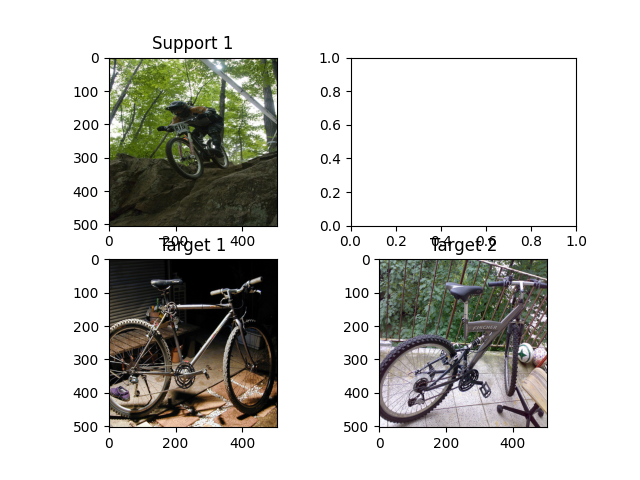

In [4]:
from PIL import Image
support_image_1 = images[12]

target_image_1 = images[16]
target_image_2 = images[5]

# load the images

support_image_1 = Image.open(support_image_1)
target_image_1 = Image.open(target_image_1)
target_image_2 = Image.open(target_image_2)

# resize to 512x512
size = 504
support_image_1 = support_image_1.resize((size, size))
target_image_1 = target_image_1.resize((size, size))
target_image_2 = target_image_2.resize((size, size))

# display the images
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(support_image_1)
ax[0, 0].set_title('Support 1')
ax[1, 0].imshow(target_image_1)
ax[1, 0].set_title('Target 1')
ax[1, 1].imshow(target_image_2)
ax[1, 1].set_title('Target 2')
plt.show()

In [5]:
# Make sure you have the necessary libraries installed
# pip install matplotlib numpy Pillow

import numpy as np
from PIL import Image



# --- Your Code Starts Here ---

# List to store the coordinates
img_coords = []

# Define the function that will be called on a mouse click
def click_callback(img_coords, ax, fig):
    def onclick(event):
        """
        This function is called when you click on the image.
        It appends the (x, y) coordinates to the 'coords' list.
        """
        # event.xdata and event.ydata are the floating point coordinates of the click
        if event.xdata is not None and event.ydata is not None:
            ix, iy = int(event.xdata), int(event.ydata)
            print(f'Clicked at x={ix}, y={iy}')
            if len(img_coords) == 0:
                img_coords.append((ix, iy))
                ax.scatter(ix, iy, c='red', s=50)
                fig.canvas.draw()
            else:
                print("Already clicked on a point")
    return onclick





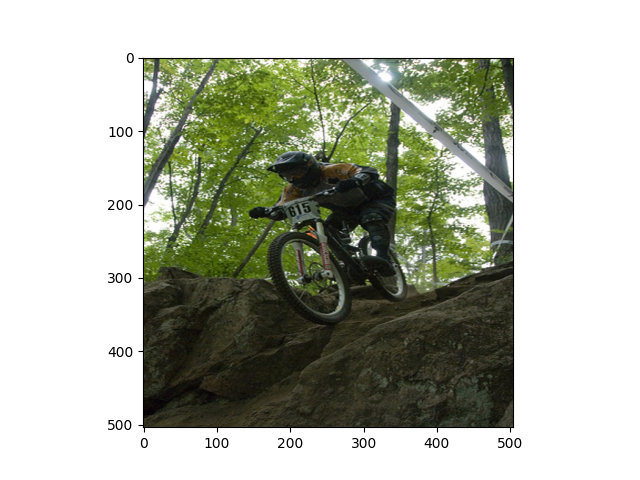

[]


In [6]:
# get coords in support image 1

# Load your image
# Replace 'your_image.png' with the actual path to your image file

# img_coords_1 = [(int(400*size/512),int(300*size/512))]
img_coords_1 = []
img = np.array(support_image_1)


# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Connect the 'button_press_event' to the 'onclick' function
cid = fig.canvas.mpl_connect('button_press_event', click_callback(img_coords_1, ax, fig))

# Show the plot
plt.show()
print(img_coords_1)

In [11]:
from few_shot_keypoints.featurizers.dino_vit_paper.featurizer import ViTPaperFeaturizer
from few_shot_keypoints.featurizers.ViT_featurizer import DinoV2SmallFeaturizer
featurizer_paper = ViTPaperFeaturizer(device='cuda:0', model_type='dinov2_vits14', stride=14, layer=11, facet='token', use_bin_features=False)
featurizer_hf = DinoV2SmallFeaturizer(device='cuda:0')

featurizers = {"hf-dinov2s": featurizer_hf, "paper-dinov2s": featurizer_paper}

Using cache found in /home/tlips/.cache/torch/hub/facebookresearch_dinov2_main


In [12]:
# check if the underlying models give the same output for the same input


In [13]:
# get feature maps of all images

from torchvision import transforms
to_tensor = transforms.ToTensor()
import torch

@torch.no_grad()
def get_feature_maps(img, featurizer):
    tmp_img = img.copy()
    tmp_img = to_tensor(tmp_img)
    tmp_img = tmp_img.unsqueeze(0)
    print(tmp_img.shape)
    return featurizer.extract_features(tmp_img).squeeze(0)



support_1_feature_maps = [get_feature_maps(support_image_1, featurizer).cpu() for featurizer in featurizers.values()]

target_1_feature_maps = [get_feature_maps(target_image_1, featurizer).cpu() for featurizer in featurizers.values()]
target_2_feature_maps = [get_feature_maps(target_image_2, featurizer).cpu() for featurizer in featurizers.values()]



torch.Size([1, 3, 504, 504])
504 504
36 36
torch.Size([1, 3, 504, 504])
torch.Size([1, 3, 504, 504])
504 504
36 36
torch.Size([1, 3, 504, 504])
torch.Size([1, 3, 504, 504])
504 504
36 36
torch.Size([1, 3, 504, 504])


In [14]:
print(img_coords_1)
u1,v1 = img_coords_1[0]
support_vectors = [support_1_feature_maps[i][:, v1, u1] for i in range(len(support_1_feature_maps))]

import torch
# get cosine similarity

target_1_similarities = [torch.nn.functional.cosine_similarity(target_1_feature_maps[i], support_vectors[i].unsqueeze(1).unsqueeze(2), dim=0) for i in range(len(support_vectors))]
target_2_similarities = [torch.nn.functional.cosine_similarity(target_2_feature_maps[i], support_vectors[i].unsqueeze(1).unsqueeze(2), dim=0) for i in range(len(support_vectors))]
# get the best match

target1_best_matches = [torch.argmax(target_1_similarities[i]) for i in range(len(target_1_similarities))]
target2_best_matches = [torch.argmax(target_2_similarities[i]) for i in range(len(target_2_similarities))]

# check the matches are the same
print(target1_best_matches)
print(target2_best_matches)


target1_unraveled = [torch.unravel_index(target1_best_matches[i], target_1_similarities[i].shape) for i in range(len(target1_best_matches))]
target1_best_matches_v = [t[0] for t in target1_unraveled]
target1_best_matches_u = [t[1] for t in target1_unraveled]

target2_unraveled = [torch.unravel_index(target2_best_matches[i], target_2_similarities[i].shape) for i in range(len(target2_best_matches))]
target2_best_matches_v = [t[0] for t in target2_unraveled]
target2_best_matches_u = [t[1] for t in target2_unraveled]


print(target1_best_matches_v)
print(target1_best_matches_u)


[(261, 256)]
[tensor(116627), tensor(116627)]
[tensor(99676), tensor(99676)]
[tensor(231), tensor(231)]
[tensor(203), tensor(203)]


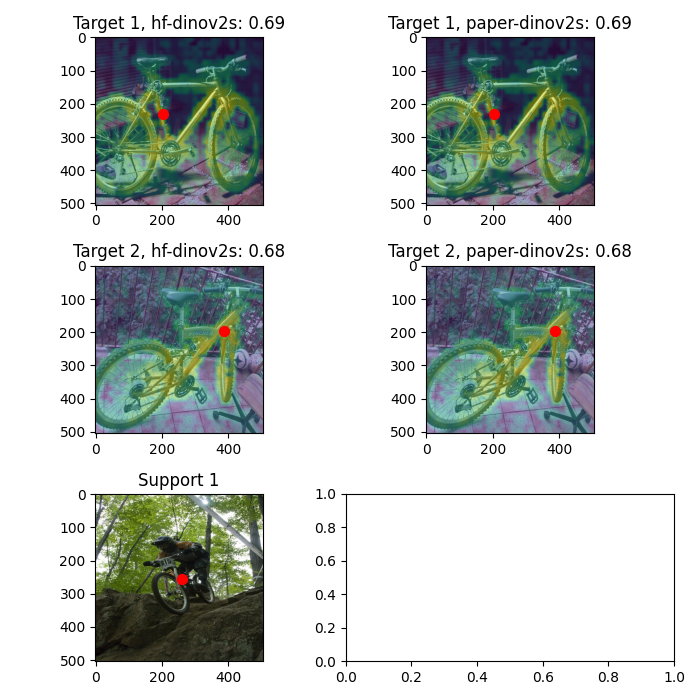

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(7, 7))

featurizer_names = list(featurizers.keys())

# Target 1 with both featurizers
for i, name in enumerate(featurizer_names):
    axs[0, i].imshow(target_image_1)
    axs[0, i].imshow(target_1_similarities[i].cpu().numpy(), cmap='viridis', alpha=0.5)
    axs[0, i].scatter(target1_best_matches_u[i].cpu().numpy(), target1_best_matches_v[i].cpu().numpy(), c='red', s=50)
    score = target_1_similarities[i][target1_best_matches_v[i], target1_best_matches_u[i]].cpu().numpy().round(2)
    axs[0, i].set_title(f'Target 1, {name}: {score:.2f}')

# Target 2 with both featurizers
for i, name in enumerate(featurizer_names):
    axs[1, i].imshow(target_image_2)
    axs[1, i].imshow(target_2_similarities[i].cpu().numpy(), cmap='viridis', alpha=0.5)
    axs[1, i].scatter(target2_best_matches_u[i].cpu().numpy(), target2_best_matches_v[i].cpu().numpy(), c='red', s=50)
    score = target_2_similarities[i][target2_best_matches_v[i], target2_best_matches_u[i]].cpu().numpy()
    axs[1, i].set_title(f'Target 2, {name}: {score:.2f}')

# Support images
axs[2, 0].imshow(support_image_1)
axs[2, 0].scatter(u1, v1, c='red', s=50)
axs[2, 0].set_title('Support 1')



plt.tight_layout()
plt.show()